In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [2]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        match_mask_color = (255,) * channel_count
    else:
        match_mask_color = 255

    cv2.fillPoly(mask, vertices, match_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [4]:
imgs = []
for img_name in os.listdir("imgs"):
    img = cv2.imread(os.path.join("imgs", img_name))
    imgs.append(img)

In [5]:
def process_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_width = img.shape[1]
    img_height = img.shape[0]

    vertices = [
        (img_width / 5, img_height),
        (img_width / 2, img_height / 1.8),
        (img_width * 4 / 5, img_height),
    ]

    img = region_of_interest(img, np.array([vertices], np.int32))
    yield img
    # gaussian blur
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # canny edge
    img = cv2.Canny(img, 100, 200)
    # remove lines caused by region of interest
    vertices_extra = [
        (img_width / 5 + 5, img_height),
        (img_width / 2, img_height / 1.8),
        (img_width * 4 / 5 - 5, img_height),
    ]
    img = region_of_interest(img, np.array([vertices_extra], np.int32))
    # yield img
    # make canny lines more visible
    img = cv2.dilate(img, np.ones((3, 3)))
    yield img

    # hough lines
    lines = cv2.HoughLinesP(
        img,
        rho=1,
        theta=np.pi / 180,
        threshold=20,
        minLineLength=2,
        maxLineGap=5,
    )
    # draw lines
    img = np.zeros((img_height, img_width), dtype=np.uint8)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), 255, 5)
    # yield img

    # determine if the rectangle ahead is straight or angled
    # find the rectangle
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # find the biggest rectangle
    biggest_rectangle = None
    biggest_rectangle_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > biggest_rectangle_area:
            biggest_rectangle_area = area
            biggest_rectangle = contour

    # find the rectangle's center
    rect = cv2.minAreaRect(biggest_rectangle)
    rect_center = rect[0]
    rect_angle = round(rect[2], 2)

    # calculate distance between bottom two points
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    bottom_left = box[np.argmin(box[:, 1])]
    bottom_right = box[np.argmax(box[:, 1])]
    bottom_line = np.linalg.norm(bottom_left - bottom_right)

    # calculate distance between top two points
    top_left = box[np.argmin(box[:, 0])]
    top_right = box[np.argmax(box[:, 0])]
    top_line = np.linalg.norm(top_left - top_right)

    ratio = top_line / bottom_line

    # set image to color
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # color drawings red
    # draw the rectangle
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img, [box], 0, (255, 0, 0), 2)
    # draw the center
    cv2.circle(img, tuple(map(int, rect_center)), 5, (255, 0, 0), -1)
    # draw the angle
    cv2.putText(
        img,
        str(rect_angle),
        tuple(map(int, rect_center)),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 0, 0),
        2,
    )
    # draw the distance
    cv2.putText(
        img,
        str(round(ratio, 2)),
        (bottom_left[0] - 50, bottom_left[1]),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 0, 0),
        2,
    )
    yield img

In [7]:
img_tmp = imgs[2].copy()
img_roi, img_can, img_hou = process_image(img_tmp)
title = ["Original Image", "Region of Interest", "Canny Edge", "Hough Lines"]


def show_imgs(imgs, title):
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    axs = axs.flatten()
    for i, img in enumerate(imgs):
        if i == 0:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img, cmap="gray")
        axs[i].set_title(title[i])
        axs[i].axis("off")
    plt.show()

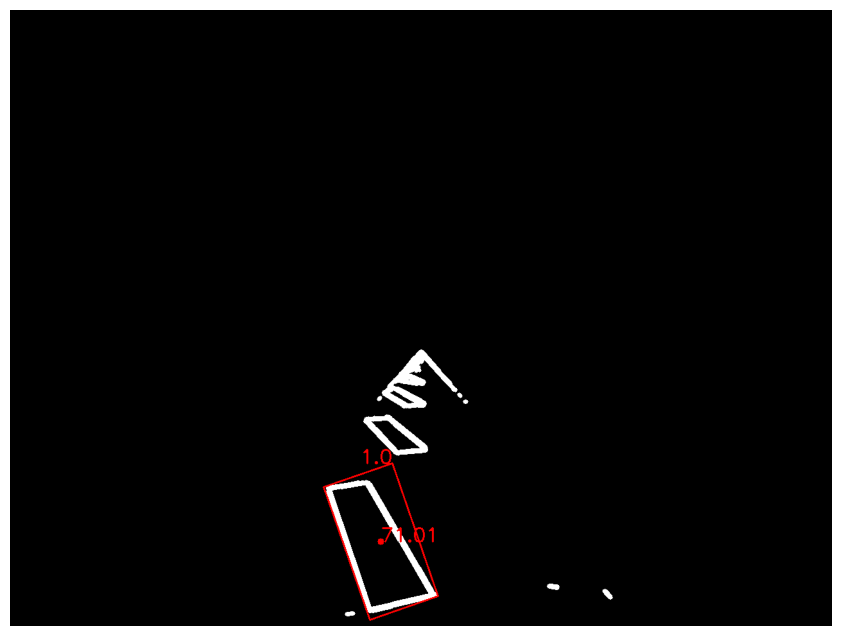

In [8]:
plt.figure(figsize=(14, 8))
plt.imshow(img_hou)
plt.axis("off")
plt.show()

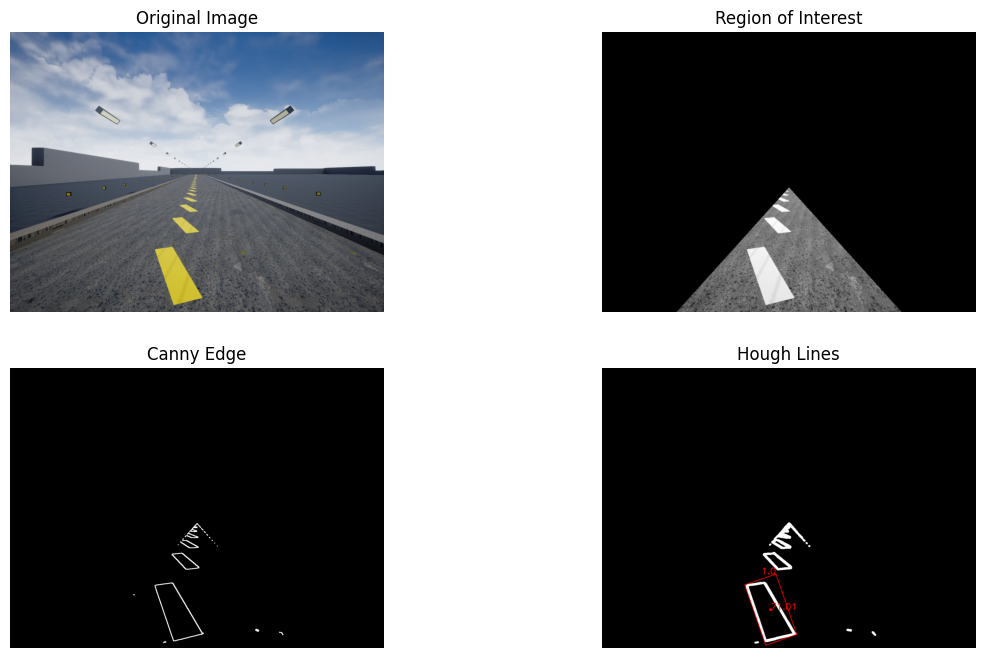

In [9]:
show_imgs([img_tmp, img_roi, img_can, img_hou], title)

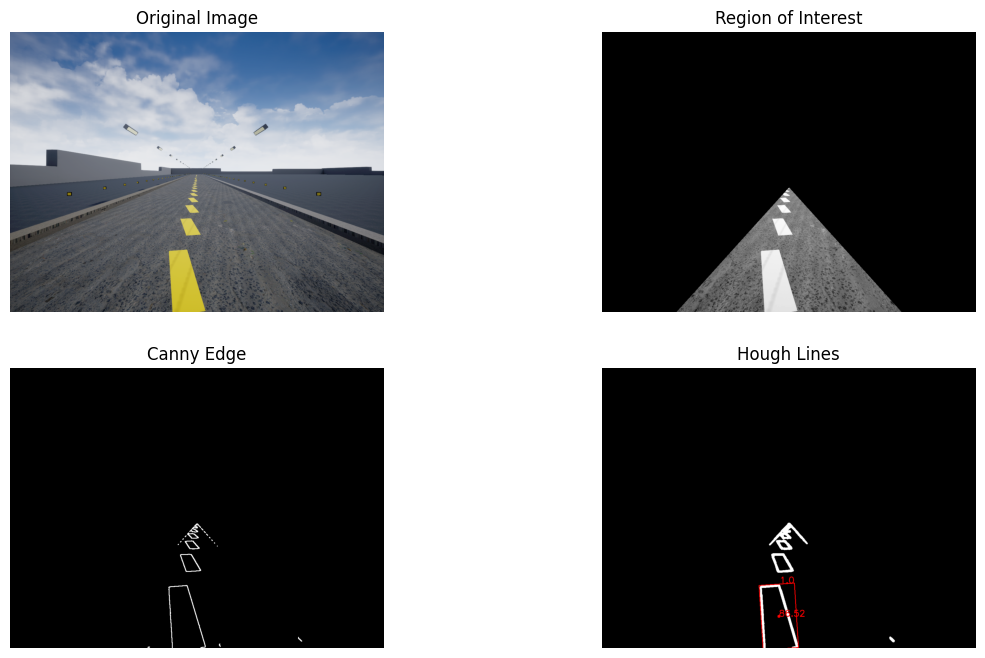

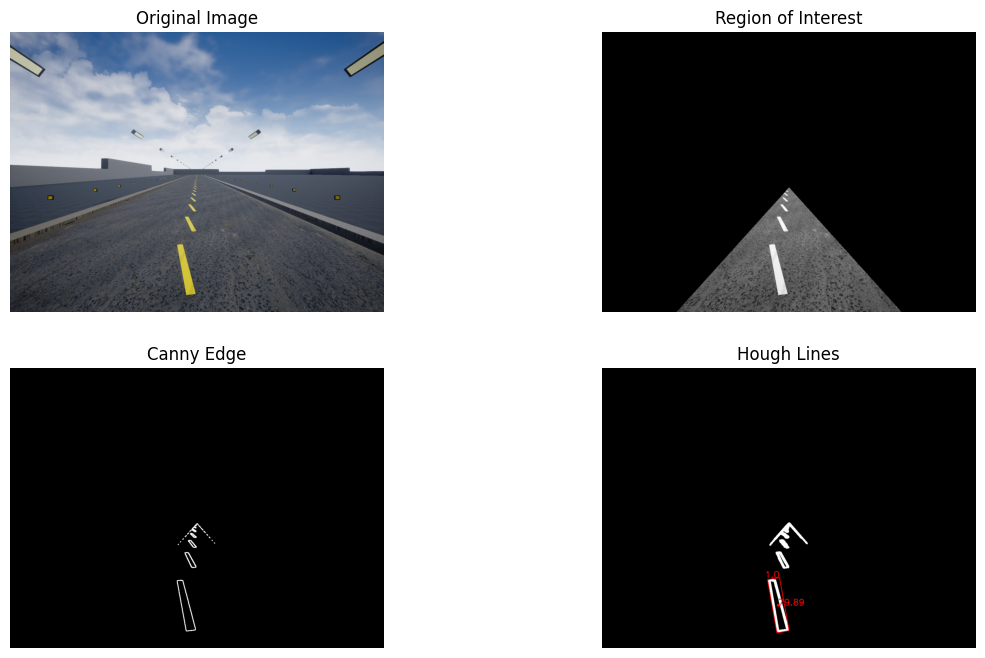

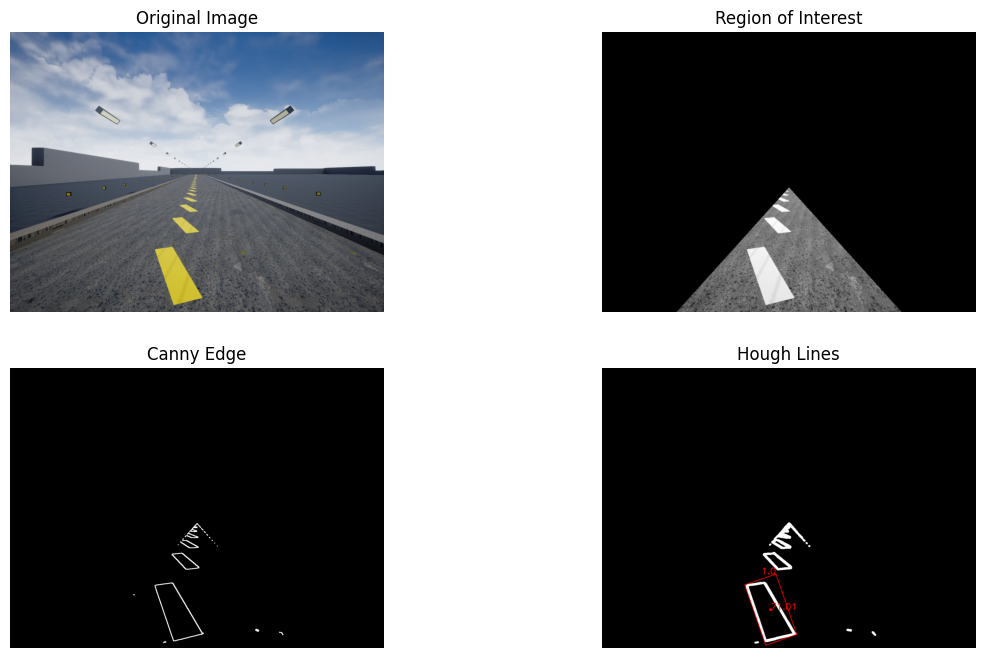

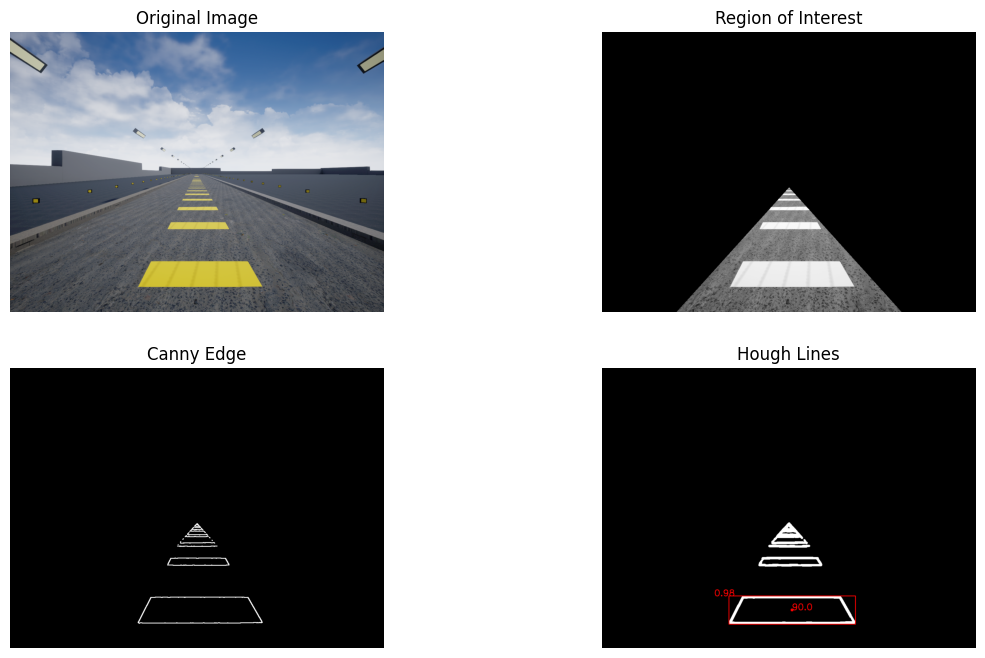

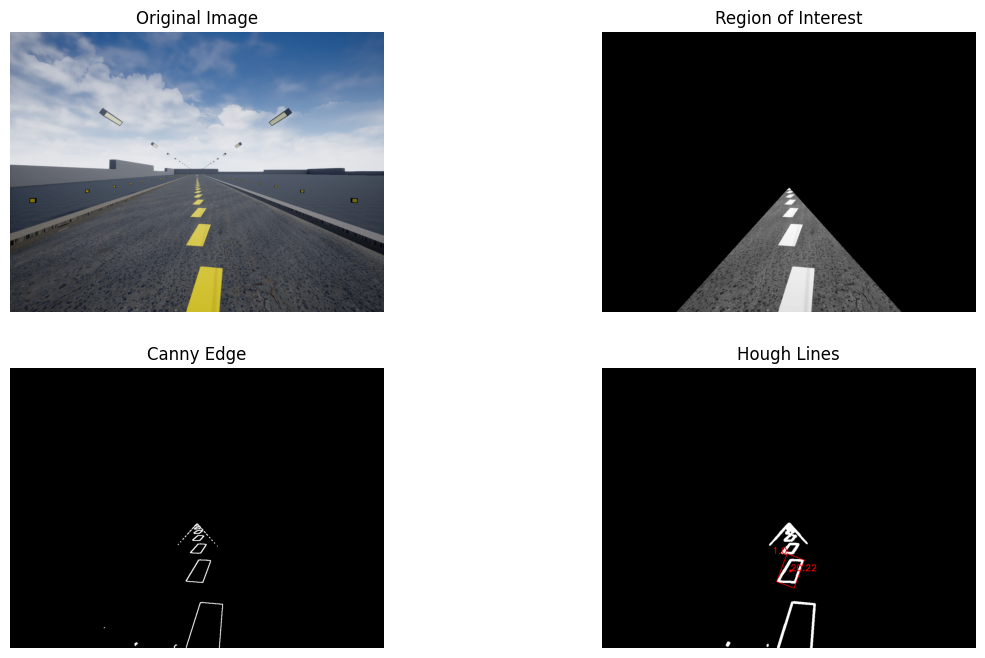

In [10]:
for i, img in enumerate(imgs):
    img_tmp = img.copy()
    img_roi, img_can, img_hou = process_image(img_tmp)
    show_imgs([img_tmp, img_roi, img_can, img_hou], title)
    img_hou = cv2.cvtColor(img_hou, cv2.COLOR_BGR2RGB)
    cv2.imwrite(os.path.join("img", f"{i+1}_hou.jpg"), img_hou)